In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import seaborn as sns
import matplotlib.pylab as pl
from scipy import signal
import scipy as sp

rcParams.update({'font.size': 13})
rcParams['figure.autolayout'] = True
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 15
rcParams['axes.titlepad'] = 10
rcParams['axes.labelpad'] = 20
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

rcParams['mathtext.fontset'] = 'cm'  
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana'] 

In [43]:
def target_functions(n_functions, time):
    functions = np.zeros((n_functions, len(time)))
    for i in range(n_functions):
        amp = np.random.uniform(1, 1.1)
        freq = (np.random.uniform(0.01, 0.02))
        functions[i, :] = [(amp * math.sin(freq * x)) for x in time]
    return functions

def target_functions_varied(n_functions, time):
    functions = np.zeros((n_functions, len(time)))
    for i in range(n_functions):
        amps = np.random.uniform(0.8, 1.2, 3)
        freqs = np.random.uniform(0.01, 0.03, 3)
        functions[i, :] = [(amps[0] * math.sin(freqs[0] * x)) + (math.sin(freqs[0]+0.005 * x)) for x in time]
    return functions

### Single readout, periodic signal

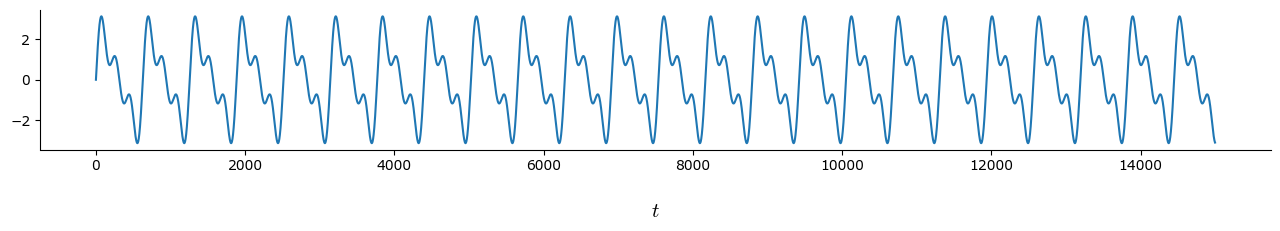

In [25]:
# Define target signal 

T = 15000  # total time for simulation 
dt = 1  # integration timestep 
iterations = int(T/dt)  # number of iterations
times = np.linspace(0, T, iterations)  # timeseries array

target = [2 * math.sin(x * 0.01) + math.sin(x * 0.02) + math.sin(x * 0.03) for x in times]

fig, ax = plt.subplots(figsize=(13, 2.5), dpi=100)
ax.plot(target)
ax.set_xlabel(r'$t$')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [10]:
# Network parameters 

N = 500  # number of neurons
g = 1.5   # synaptic gain
alpha = 1  # regularisation term for P matrix
tau = 20  # time constant
dt_weight_update = 10  # weight update time step

learn_min = int(T/20)  # time to start training
learn_max = int(T*8/10)  # time to stop training


# Initialisation 

J = np.random.randn(N, N) * g / np.sqrt(N)  # recurrent weights
ones = np.ones((N, N))
ones_diag = np.eye(N)
J = J*(ones - ones_diag)  # remove diagonals

wf = np.random.uniform(-1, 1, N)  # feedback weights 

xs = np.zeros((N, iterations)) # internal activations
x0 = np.random.randn(N)  # initial internal activations 
x = x0

wrs = np.zeros((N, iterations)) # readout weights
wr0 = np.random.randn(N) * 1/N  # initial readouts 
wr = wr0

z = np.zeros(iterations) # to store readouts
z[0] = np.random.randn() * 0.1 # initial readout 

P = np.eye(N) / alpha  # initial P 

deltas = np.zeros(iterations)  # to store weight change

# Training

for t in range(iterations - 1):
    wrs[:, t] = wr  
    xs[:, t] = x
    x = x + (-x + J.dot(np.tanh(x)) + wf * z[t]) * dt / tau 
    r = np.tanh(x)  
    r = r[:, None]
    z[t + 1] = wr.T.dot(r)  

    if t > learn_min and t % dt_weight_update == 0 and t < learn_max:
        e = z[t + 1] - target[t]  
        c = 1 / (1 + r.T.dot(P.dot(r)))
        P = P - (P.dot(r.dot(r.T.dot(P)))) / (1 + r.T.dot(P.dot(r)))
        delta_w = - (c * e * (P.dot(r)))
        deltas[t] = np.linalg.norm(delta_w) 
        wr += delta_w[:, 0]


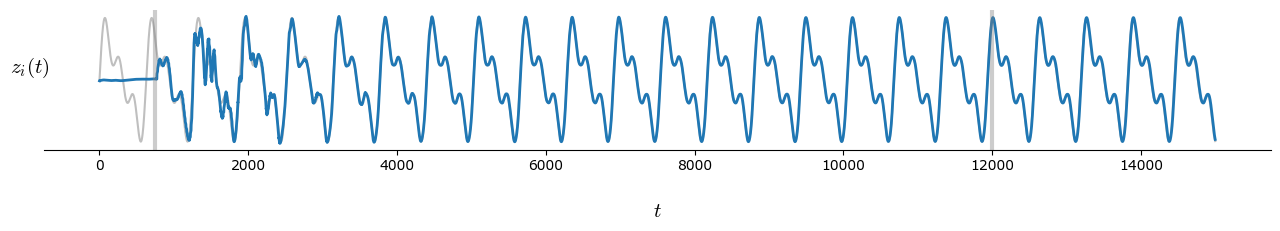

In [24]:
# Plot readout versus target

fig, ax = plt.subplots(figsize=(13, 2.5), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))

ax.plot(target, color='grey', alpha=0.5)   # target function
ax.plot(z, linewidth=2)  # readout

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('$z_i(t)$', rotation=0, labelpad=10)
ax.set_xlabel(r'$t$')

ax.axvline(x=learn_min, linewidth=3, color='grey', alpha=0.4) 
ax.axvline(x=learn_max, linewidth=3, color='grey', alpha=0.4)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

fig.tight_layout()
plt.show()



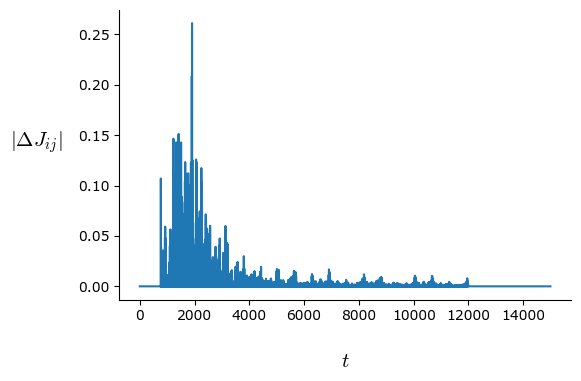

In [30]:
# Plot change in weights

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(deltas)
ax.set_ylabel(r'$| \Delta J_{ij} |$', rotation=0, labelpad=30)
ax.set_xlabel(r'$t$')
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()

### Single readout - embedded, periodic signal

In [31]:
# Network parameters 

N = 500  # number of neurons
g = 1.5   # synaptic gain
alpha = 1  # regularisation term for P matrix
tau = 20  # time constant
dt_weight_update = 10  # weight update time step

learn_min = int(T/20)  # time to start training
learn_max = int(T*9/10)  # time to stop training


# Initialisation 

J0 = np.random.randn(N, N) * g / np.sqrt(N)  # recurrent weights 
J = J0
ones = np.ones((N, N))
ones_diag = np.eye(N)
J0 = J0*(ones - ones_diag)  # remove diagonals

xs = np.zeros((N, iterations))
x0 = np.random.randn(N)  # initial activations
x = x0

zs = np.zeros((N, iterations))  # Store readout for signal target
zs[:, 0] = np.random.randn(N) * 0.1  # initial readout 

P = np.eye(N) / alpha  # initial P 

deltas = np.zeros(iterations)  # store weight change


# Training

for t in range(iterations - 1):
    xs[:, t] = x
    x = x + (-x + J.dot(np.tanh(x)) + J[:, 0] * np.sqrt(N)/g * np.tanh(x[0])) * dt / tau  # x0 needs to send large outgoing weights to rest of network 
    r = np.tanh(x)  
    r = r[:, None]
    zs[0, t + 1] = J[0, :].dot(r)  

    if t > learn_min and t % dt_weight_update == 0 and t < learn_max:
        e = zs[0, t + 1] - target[t]  
        c = 1 / (1 + r.T.dot(P.dot(r))) 
        P = P - (P.dot(r.dot(r.T.dot(P)))) / (1 + r.T.dot(P.dot(r)))
        delta_w = - (c * e * (P.dot(r)))
        deltas[t] = np.linalg.norm(delta_w) 
        J[0, :] += delta_w[:, 0]
        J[0, 0] = 0



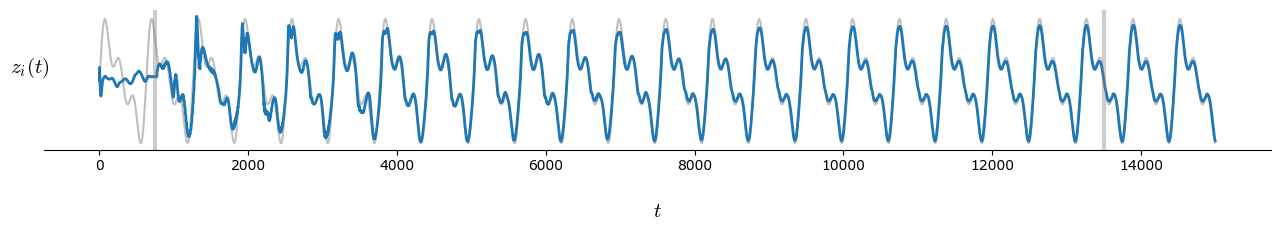

In [33]:
# Plot readout versus target

fig, ax = plt.subplots(figsize=(13, 2.5), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))

ax.plot(target, color='grey', alpha=0.5)   # target function
ax.plot(zs[0, :], linewidth=2)  # readout

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('$z_i(t)$', rotation=0, labelpad=10)
ax.set_xlabel(r'$t$')

ax.axvline(x=learn_min, linewidth=3, color='grey', alpha=0.4) 
ax.axvline(x=learn_max, linewidth=3, color='grey', alpha=0.4)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

fig.tight_layout()
plt.show()


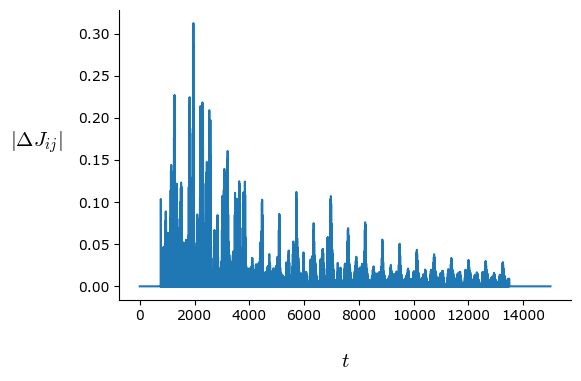

In [34]:
# Plot change in weights

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(deltas)
ax.set_ylabel(r'$| \Delta J_{ij} |$', rotation=0, labelpad=30)
ax.set_xlabel(r'$t$')
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()

### Several readouts - embedded, periodic signal

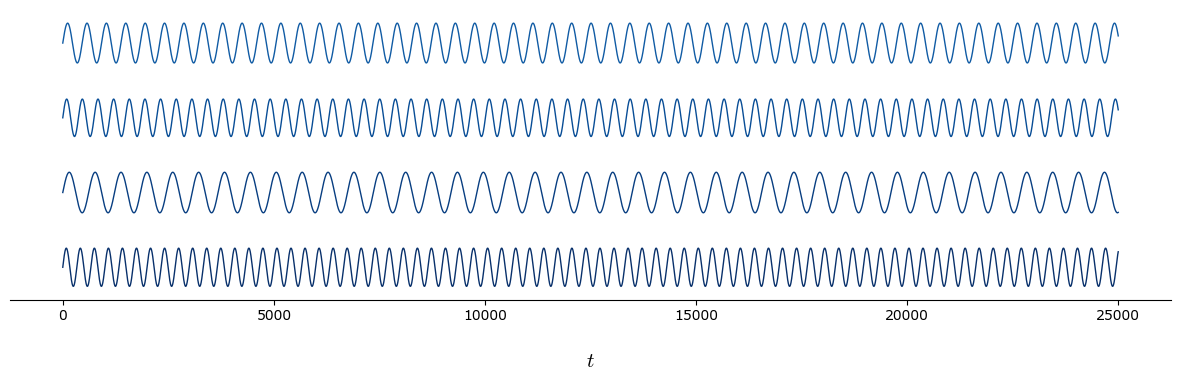

In [37]:
# Target signals

n_targets = 4

T = 25000  # total time for simulation 
dt = 1  # integration timestep 
iterations = int(T/dt)  # number of iterations
times = np.linspace(0, T, iterations)  # timeseries array

targets = target_functions(n_targets, times)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))
for i in range(n_targets):
    ax.plot(targets[i] + i*4, lw=1, color=colors[i])
    
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$')
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()



In [38]:
# Network parameters 

N = 300  # number of neurons
g = 1.5   # synaptic gain
alpha = 1  # regularisation term for P matrix
tau = 20  # time constant
dt_weight_update = 10  # weight update time step

learn_min = int(T/20)  # time to start training
learn_max = int(T*8/10)  # time to stop training


# Initialisation 

J0 = np.random.randn(N, N) * g / np.sqrt(N)  # recurrent weights 
J = J0

xs = np.zeros((N, iterations))
x0 = np.random.randn(N)  # initial activations
x = x0

zs = np.zeros((N, iterations))  # Store readout for signal target
zs[:, 0] = np.random.randn(N) * 0.1  # initial readout 

P = np.eye(N) / alpha  # initial P 

deltas = np.zeros((N, iterations))  # store weight change 


# Training

for t in range(iterations - 1):
    xs[:, t] = x
    x = x + (-x + J.dot(np.tanh(x))) * dt / tau 
    r = np.tanh(x)  
    r = r[:, None]  
    zs[:, t+1] = J.dot(np.squeeze(r))  # each z_i is J[i, :].dot(r)

    if t > learn_min and t % dt_weight_update == 0 and t < learn_max:
        
        c = 1/(1 + r.T.dot(P.dot(r)))
        P = P - (P.dot(r.dot(r.T.dot(P)))) / (1 + r.T.dot(P.dot(r)))
        
        for i in range(n_targets):
            e = zs[i, t + 1] - targets[i, t] 
            delta_w = - (c * e * (P.dot(r)))
            deltas[i, t] = np.linalg.norm(delta_w)
            J[i, :] += delta_w[:, 0]

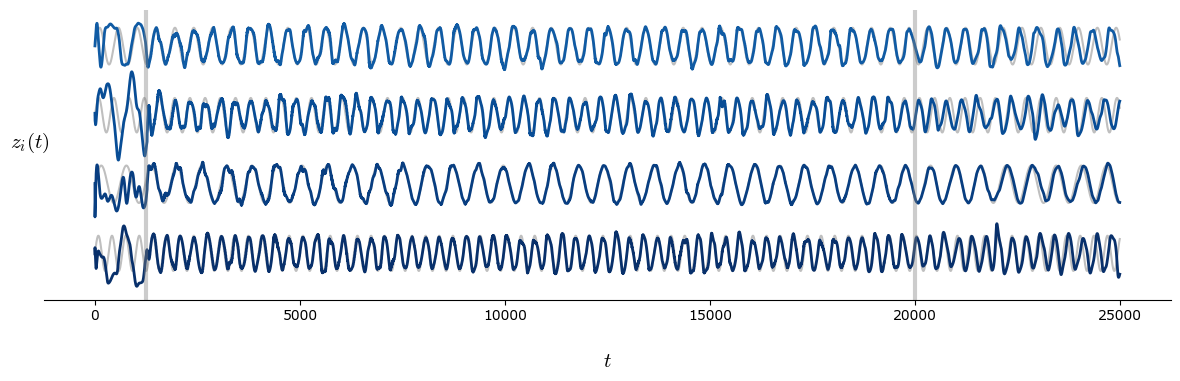

In [40]:
# Plot readout versus target

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))

for i in range(n_targets):
    ax.plot(targets[i] + i * 4, color='grey', alpha=0.5)   # Target functions
    ax.plot(zs[i, :] + i * 4, color=colors[i], linewidth=2)  # Network firing rates

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('$z_i(t)$', rotation=0, labelpad=10)
ax.set_xlabel(r'$t$')

ax.axvline(x=learn_min, linewidth=3, color='grey', alpha=0.4) 
ax.axvline(x=learn_max, linewidth=3, color='grey', alpha=0.4)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)

fig.tight_layout()
plt.show()


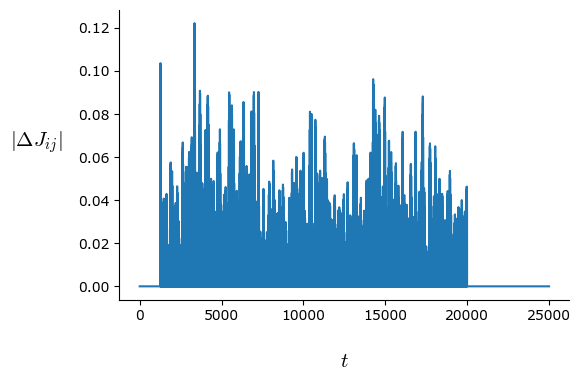

In [41]:
# Plot change in weights

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(deltas[0]) # choose which weights
ax.set_ylabel(r'$| \Delta J_{ij} |$', rotation=0, labelpad=30)
ax.set_xlabel(r'$t$')
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()

### All readouts - embedded, periodic signal

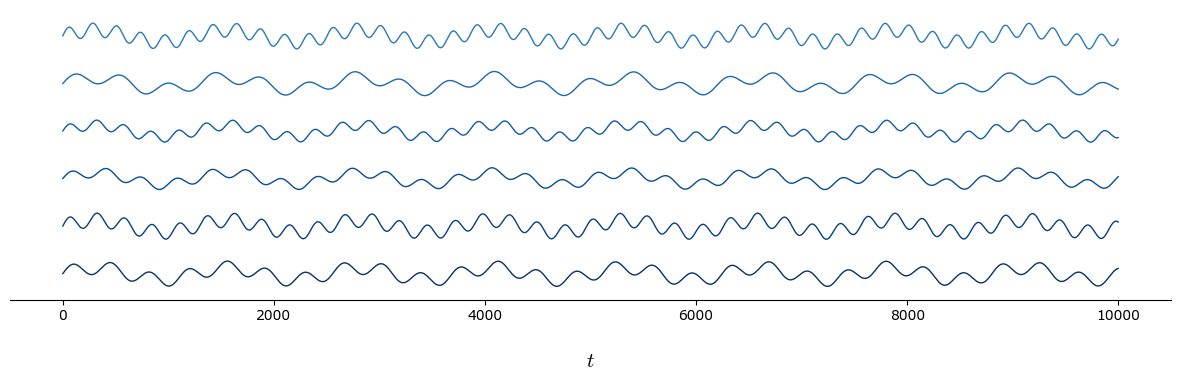

In [44]:
# Network parameters

N = 200
n_targets = int(N)

T = 10000  
dt = 1  
iterations = int(T/dt) 
times = np.linspace(0, T, iterations)  

# Noise signal 

tau_wn = 0.1
amp_wn = np.sqrt(tau_wn)  # amplitude of the white noise 
amp_wn_input = 0.01

white_noise = amp_wn * np.random.randn(N, iterations)
noise_input = np.ones((N, iterations))
for i in range(1, iterations):
    noise_input[:, i] = white_noise[:, i] + (noise_input[:, i-1] - white_noise[:, i]) * np.exp(-(dt/tau_wn))
noise_input = amp_wn_input * noise_input


# Target signals 

targets = target_functions_varied(n_targets, times)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))
for i in range(6):
    ax.plot(targets[i] + i*8, lw=1, color=colors[i])
ax.set_xlabel(r'$t$')
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [45]:
# Network parameters 

g = 2.0   # synaptic gain
alpha = 1  # regularisation term for P matrix
tau = 20  # time constant  
dt_weight_update = 10 # weight update time step

n_train = 20
n_free = 1
n_tot = n_train + n_free  # total number of runs 

# Initialisation 

J0 = np.random.randn(N, N) * g / np.sqrt(N)  # recurrent weights 
J = J0

P = np.eye(n_targets) / alpha  # initial P 

zs_all = []  # store readouts from all runs 

deltas_all = np.zeros(n_targets)  # store change in weight from all runs 
deltas_all = deltas_all[:, None]

for run in range(n_tot):

    xs = np.zeros((N, iterations))  # store activations   
    xs[:n_targets, 0] = targets[:, 0]  # set activations to initial condition of targets
    x = xs[:, 0]
    zs = np.zeros((N, iterations))  # store readouts
    deltas = np.zeros((n_targets, iterations)) # store change in weights 

    # Training
    
    for t in range(iterations-1):
        xs[:, t] = x
        
        x = x + (-x + J.dot(np.tanh(x)) + noise_input[:, t]) * dt / tau 
    
        r = np.tanh(x)  
        r = r[:, None] 
        zs[:, t+1] = J.dot(np.squeeze(r))  # each z_i is J[i, :].dot(r)

        if run < n_train and t % dt_weight_update == 0:
            
            errs = zs[:n_targets, t+1] - targets[:, t+1]
            k = P.dot(r[:n_targets])
            rPr = r[:n_targets].T.dot(k)
            c = 1.0 / (1.0 + rPr)
            P = P - c * (k.dot(k.T))  # should update P after weight update
            delta_w = - (c * np.outer(errs, k))
            deltas[:, t] = np.linalg.norm(delta_w, axis=0)
            J[:n_targets, :n_targets] += delta_w

    zs_all.append(zs)
    deltas_all = np.concatenate((deltas_all, deltas), axis=1)

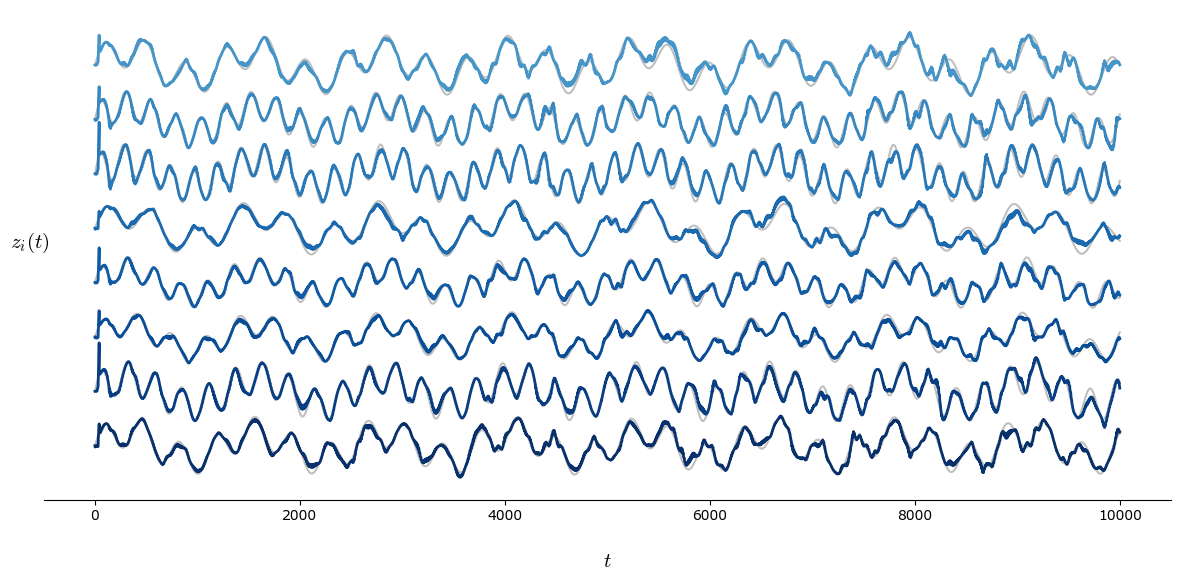

In [46]:
# Plot readout versus target

fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
colors = pl.cm.Blues_r(np.linspace(0, 0.5, 10))

for i in range(8):
    ax.plot(targets[i, :] + i * 4, color='grey', alpha=0.5)   # Target functions
    ax.plot(zs_all[0][i, :] + i * 4, color=colors[i], linewidth=2)  # Network firing rates

ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('$z_i(t)$', rotation=0, labelpad=10)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
ax.set_xlabel(r'$t$')
fig.tight_layout()
plt.show()


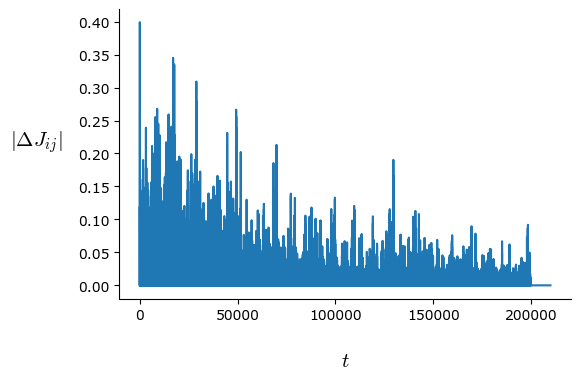

In [50]:
# Plot change in weights

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(deltas_all[0]) # choose which weights
ax.set_ylabel(r'$| \Delta J_{ij} |$', rotation=0, labelpad=30)
ax.set_xlabel(r'$t$')
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
fig.tight_layout()
plt.show()